# Deep Learning Mini-Challenge 1: Image Classification

**Author**: Lukas Reber

**Task**: Train a neural network to classify images from the CIFAR-10 dataset. Focus will be on the training and evaluation of the model, not on the data preprocessing. We will use PyTorch to implement a Multi Layer Perceptron (MLP) and a Convolutional Neural Network (CNN) to classify images the images.

**Dataset**: The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5,000 images from each class.

## Import dependencies & load data

In [221]:
import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import wandb
from datetime import datetime
import pandas as pd
import seaborn as sns

In [40]:
# login to w&b
wandb.login()

True

In [32]:
# check if gpu support on the m1 mac or cuda is available
if torch.backends.mps.is_available() & torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [33]:
# ensure deterministic behavior
torch.manual_seed(10)
np.random.seed(10)

We can directly load the CIFAR-10 dataset from PyTorch's `torchvision` package. Since the data consists of images or range [0,255], we normalize the data to range [0,1]. (RGB values range from 0-255, therefore by dividing by 255 we normalize the data to range [0,1].)

In [34]:
# load the data and normalize it

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

print(f'Shape: {cifar_train.data.shape}')

Files already downloaded and verified
Files already downloaded and verified
Shape: (50000, 32, 32, 3)


We now have the data in the correct shape and range. As we can see, there are 50000 training images, with three layers (RGB) and 32x32 pixels each. We can look at some random images from the training set to get a better idea of the data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

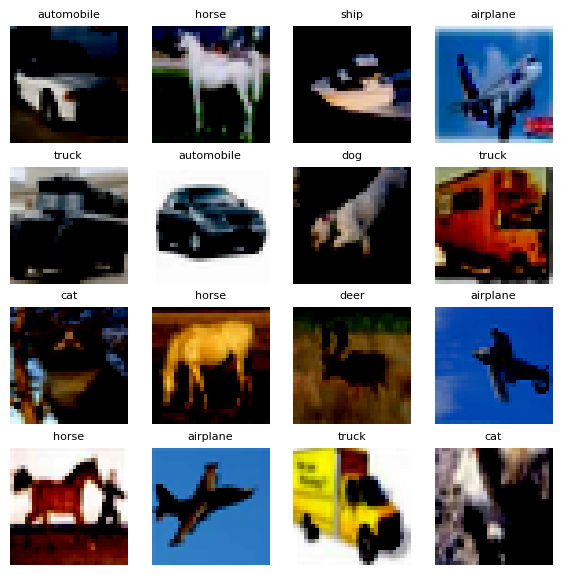

In [15]:
# plot sample images
rand_idx = np.random.randint(0, len(cifar_train), 16)
fig, axs = plt.subplots(4,4, figsize=(7,7))
for i, ax in enumerate(axs.flat):
    ax.imshow(cifar_train[rand_idx[i]][0].permute(1,2,0))
    ax.set_title(cifar_train.classes[cifar_train[rand_idx[i]][1]], size=8)
    ax.axis('off')
plt.show()

We can also see that the classes are balanced in the dataset.

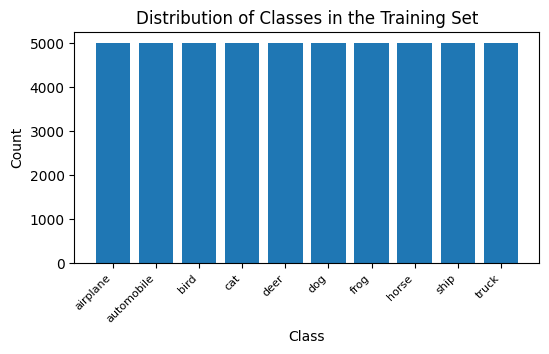

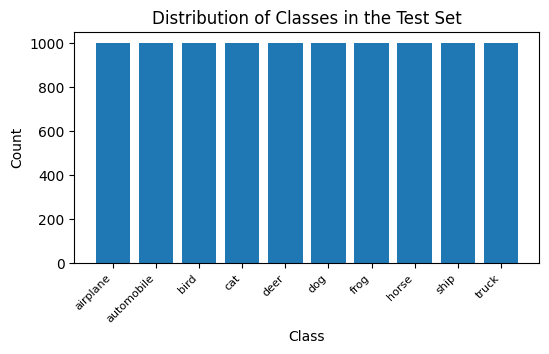

In [6]:
# display distribution of classes
values, counts = np.unique(cifar_train.targets, return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(6,3))
ax.bar(values, counts)
ax.set_title('Distribution of Classes in the Training Set')
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_xticks(values)
ax.set_xticklabels(cifar_train.classes, rotation=45, ha='right', size=8)
plt.show()

values, counts = np.unique(cifar_test.targets, return_counts=True)

fig, ax = plt.subplots(1,1, figsize=(6,3))
ax.bar(values, counts)
ax.set_title('Distribution of Classes in the Test Set')
ax.set_ylabel('Count')
ax.set_xlabel('Class')
ax.set_xticks(values)
ax.set_xticklabels(cifar_test.classes, rotation=45, ha='right', size=8)
plt.show()

Source:

- https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- 

In [122]:
def calc_true(pred, labels):
    pred_labels = torch.argmax(pred, dim=1)
    return (pred_labels == labels).float().sum()

def model_eval(model, data, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for d in data:
            x_test, y_test = d[0].to(device), d[1].to(device)
            outputs = model(x_test)
            _, predicted = torch.max(outputs.data, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
    
    return correct / total

def model_training(modelclass, optimizer, traindata, testdata, criterion, epochs, device):

    model = modelclass()
    model = model.to(device)
    optimizer = optimizer(model)

    # stats = {
    #     'loss': [],
    #     'train_acc': [],
    #     'test_acc': []
    # }
    
    # wand watch not yet supportet for mps devices
    if device.type != 'mps':
       wandb.watch(model, criterion, log="all")

    for epoch in range(epochs):
        train_acc = 0
        # running_loss = 0.0
        for i, data in enumerate(traindata, 0):
            # get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # backward pass + zero the parameter gradients
            optimizer.zero_grad()
            loss.backward()

            # step with optimizer
            optimizer.step()

            # statistics
            # stats['loss'].append(loss.item())
            train_acc += calc_true(outputs, labels)
            wandb.log({'loss': loss.item()})
            # running_loss += loss.item()
            # if i % 100 == 0:    # print every 100 mini-batches
            #     print(f'epoch: {epoch+1}, iteration: {i} loss: {running_loss / 100:.3f}')
            #     running_loss = 0.0

        epoch_test_acc = train_acc.item() / len(traindata.dataset)
        epoch_train_acc = model_eval(model, testdata, device)
        # stats['train_acc'].append(epoch_test_acc)
        # stats['test_acc'].append(epoch_train_acc)
        wandb.log({'train_acc': epoch_test_acc, 'test_acc': epoch_train_acc})


In [218]:
def get_logs(sweep_id):
    api = wandb.Api()

    # get a sweep
    sweep = api.sweep(f"lukas_fhnw/del_mc1/sweeps/{sweep_id}")

    # get all runs for a sweep
    runs = list(sweep.runs)

    names = pd.DataFrame([run.name for run in runs])

    # define the keys to extract from the summary
    summary_keys = ['_step','_runtime','_timestamp','test_acc', 'train_acc', 'loss']
    # extract values for each run and create a dataframe
    summaries = pd.DataFrame([{ key:value for key,value in run.summary.items() if key in summary_keys} for run in runs])
    #merge the names into the summaries
    summaries = pd.concat([names, summaries], axis=1)
    summaries.rename(columns={0:'run'}, inplace=True)
    
    # extract all config values for each run and create a dataframe
    configs = pd.DataFrame([run.config for run in runs])
    #merge the names into the configs
    configs = pd.concat([names, configs], axis=1)
    configs.rename(columns={0:'run'}, inplace=True)

    # extract all history values for each run and create a dataframe
    accuracies = pd.DataFrame()
    losses = pd.DataFrame()
    for run in runs:
        acc = run.history(keys=['train_acc', 'test_acc'])
        # acc = pd.DataFrame([row for row in acc])
        acc['run'] = run.name
        accuracies = pd.concat([accuracies, acc])

        loss = run.history(keys=['loss'])
        # loss = pd.DataFrame([row for row in loss])
        loss['run'] = run.name
        losses = pd.concat([losses, loss])

    return summaries, configs, accuracies, losses

In [300]:
def plot_results(summaries,configs,accuracies):
    # prepare data
    merged_data = pd.merge(summaries, configs, on='run')

    # plot results
    fig, axes = plt.subplots(3, figsize=(15,20))

    # Test Accuracy
    ax = sns.lineplot(data=accuracies, x='_step', y='test_acc', hue='run', ax=axes[0])
    ax.set(xlabel='Epochs')
    ax.title.set_text('Test Accuracy')

    # Train Accuracy
    ax2 = sns.lineplot(data=accuracies, x='_step', y='train_acc', hue='run', ax=axes[1])
    ax2.set(xlabel='Epochs')
    ax2.title.set_text('Train Accuracy')

    # Heatmap
    ax3 = sns.heatmap(pd.pivot_table(merged_data,index='batch_size',columns='learning_rate',values='test_acc',aggfunc='max'), annot=True, ax=axes[2])
    ax3.set(xlabel='Learning Rate', ylabel='Batch Size')
    ax3.title.set_text('Test Accuracy over Learning Rate & Batch Size')
    plt.show()

    # explain the results
    best_run = merged_data.iloc[merged_data['test_acc'].idxmax()]
    print(f'Best Test Accuracy: {best_run.test_acc}, with Batch Size {best_run.batch_size} and Learning Rate {best_run.learning_rate}' )
    

# Multi Layer Perceptron (MLP)

In [17]:
# Model 1: MLP with 1 hidden layer
class MLP_1(nn.Module):
    
    def __init__(self, input_size, output_size, fc1_size, fc2_size):
        super(MLP_1, self).__init__()
        
        self.fc1 = nn.Linear(input_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, output_size)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [124]:
def train_mlp_1(config=None):
    with wandb.init(config=config) as run:

        config = wandb.config

        wandb.run.name=f'{config.architecture}_lr{config.learning_rate}_bs{config.batch_size}_{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}'

        if config.optimizer == 'sgd':
            optimizer = lambda model: torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == 'adam':
            optimizer = lambda model: torch.optim.Adam(model.parameters(), lr=config.learning_rate)

        model_training(
            modelclass=lambda: MLP_1(config.input_size, config.output_size, config.hidden_layers[0], config.hidden_layers[1]),
            optimizer=optimizer,
            traindata=torch.utils.data.DataLoader(cifar_train, batch_size=config.batch_size, shuffle=True),
            testdata=torch.utils.data.DataLoader(cifar_test, batch_size=config.batch_size, shuffle=True),
            criterion=nn.CrossEntropyLoss(),
            epochs=config.epochs,
            device=device
        )

In [ ]:
# try sweep config
sweep_config = {
    'name': 'MLP_sweep',
    'method': 'grid',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'epochs': {
            'value': 10
            },
        'batch_size': {
            'values': [20, 50, 100, 200],
        },
        'learning_rate': {
            'values': [0.01, 0.1, 0.2]
        },
        'architecture': {
            'value': 'mlp'
        },
        'optimizer': {
            'value': 'sgd'
        },
        'loss': {
            'value': 'CrossEntropyLoss'
        },
        'activation': {
            'value': 'relu'
        },
        'hidden_layers': {
            'values': [(128, 64)]
        },
        'input_size': {
            'value': 32*32*3
        },
        'output_size': {
            'value': 10
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="del_mc1")
wandb.agent(sweep_id, function=train_mlp_1)

## Evaluation

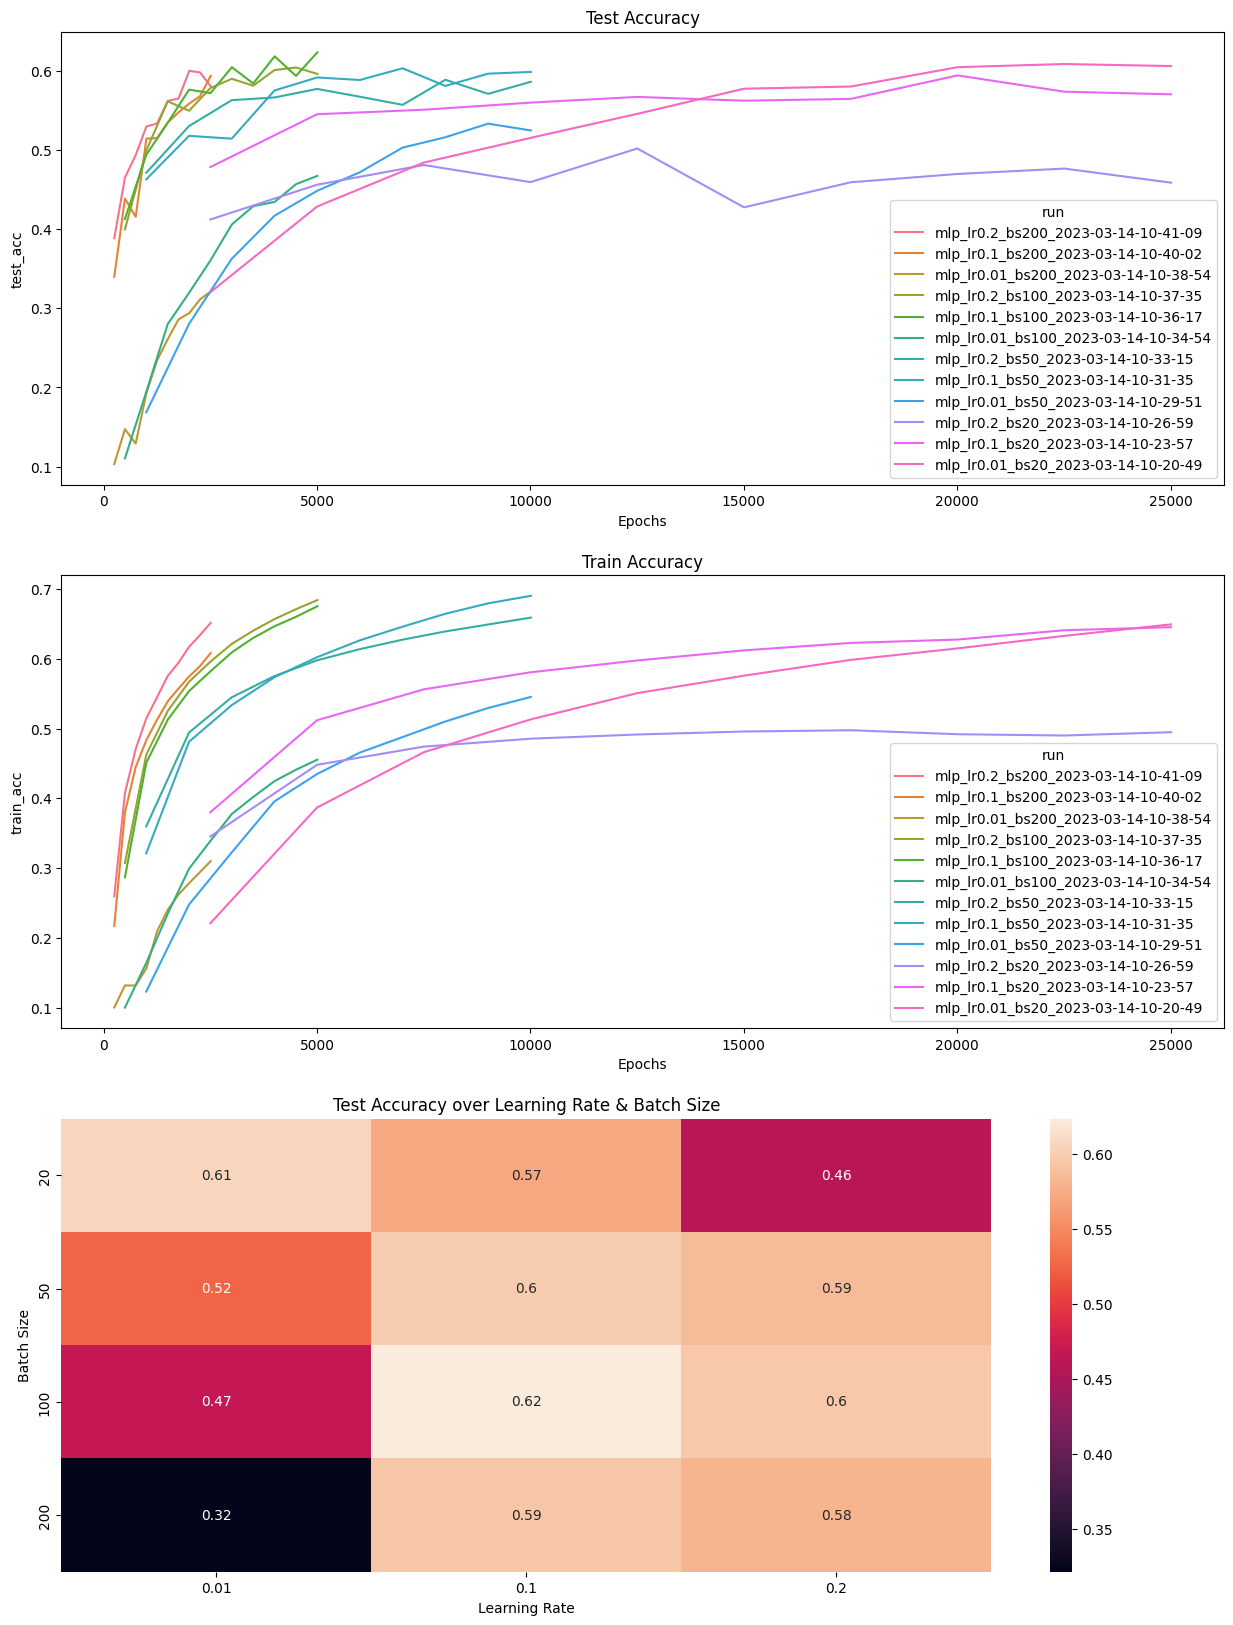

Best Test Accuracy: 0.6237, with Batch Size 100 and Learning Rate 0.1


In [301]:
summary, configs, accuracies, losses = get_logs(sweep_id)

plot_results(summary, configs, accuracies)

# Convolutional Neural Network (CNN)

In [27]:
# Model 2: CNN
class CNN_1(nn.Module):
    
    def __init__(self, conv1_layer, conv2_layer, kernel_size, output_size, fc1_size, fc2_size):
        super(CNN_1, self).__init__()

        self.conv1 = nn.Conv2d(3, conv1_layer, kernel_size=kernel_size) #in_channels = 3 (RGB), out_channels = no of feature maps, kernel_size = size of filter
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, conv2_layer, kernel_size=kernel_size)
        
        self.fc1 = nn.Linear(conv2_layer*5*5, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, output_size)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [28]:
def train_cnn_1(config=None):
    with wandb.init(config=config) as run:

        config = wandb.config

        wandb.run.name=f'{config.architecture}_lr{config.learning_rate}_bs{config.batch_size}_{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}'

        if config.optimizer == 'sgd':
            optimizer = lambda model: torch.optim.SGD(model.parameters(), lr=config.learning_rate)
        elif config.optimizer == 'adam':
            optimizer = lambda model: torch.optim.Adam(model.parameters(), lr=config.learning_rate)

        model_training(
            modelclass=lambda: CNN_1(config.conv_layers[0], config.conv_layers[1], config.kernel_size, config.output_size, config.hidden_layers[0], config.hidden_layers[1]),
            optimizer=optimizer,
            traindata=torch.utils.data.DataLoader(cifar_train, batch_size=config.batch_size, shuffle=True),
            testdata=torch.utils.data.DataLoader(cifar_test, batch_size=config.batch_size, shuffle=True),
            criterion=nn.CrossEntropyLoss(),
            epochs=config.epochs,
            device=device
        )

In [29]:
sweep_config = {
    'name': 'CNN_sweep',
    'method': 'grid',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'epochs': {
            'value': 10
            },
        'batch_size': {
            'values': [20, 50, 100, 200]
        },
        'learning_rate': {
            'values': [0.01, 0.1, 0.2]
        },
        'architecture': {
            'value': 'cnn'
        },
        'optimizer': {
            'value': 'sgd'
        },
        'loss': {
            'value': 'CrossEntropyLoss'
        },
        'activation': {
            'value': 'relu'
        },
        'hidden_layers': {
            'values': [(128, 64)]
        },
        'conv_layers': {
            'values': [(6, 16)]
        },
        'input_size': {
            'value': 32*32*3
        },
        'output_size': {
            'value': 10
        },
        'kernel_size': {
            'value': 5
        },

    }
}

sweep_id = wandb.sweep(sweep_config, project="del_mc1")
wandb.agent(sweep_id, function=train_cnn_1)

Create sweep with ID: 1bnlu23w
Sweep URL: https://wandb.ai/lukas_fhnw/del_mc1/sweeps/1bnlu23w


wandb: Agent Starting Run: friplc3t with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 20
wandb: 	conv_layers: [6, 16]
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: sgd
wandb: 	output_size: 10


loss,██▇▆▅▇▅▄▅▃▃▅▆▆▄▄▂▄▅▂▅▁▃▂▂▂▃▃▃▃▂▁▁▂▂▃▃▁▁▂
test_acc,▁▄▅▆▆▇▇███
train_acc,▁▄▅▆▆▇▇▇██
loss,1.26675
test_acc,0.6063
train_acc,0.64906


wandb: Agent Starting Run: 7uf4xm7w with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 20
wandb: 	conv_layers: [6, 16]
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.1
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: sgd
wandb: 	output_size: 10


loss,█▆▇▅▄▅▄▄▆▅▆▃▃▃▅▂▅▃▅▄▆▅▄▃▅▄▄▄▂▂▃▁▄▃▂▃▅▄▃▁
test_acc,▁▅▅▆▆▆▆█▇▇
train_acc,▁▄▆▆▇▇▇███
loss,1.10469
test_acc,0.5706
train_acc,0.64506


wandb: Agent Starting Run: irzg0533 with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 20
wandb: 	conv_layers: [6, 16]
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.2
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: sgd
wandb: 	output_size: 10


loss,▇▆▇▅▄▂▅▁▅▃▄▃▃▅▅█▃▁▁▅▃▄▄▅▅▅▅▄▆▃▂▆▁▆▄▆▄▃▄▃
test_acc,▁▄▆▅█▂▅▅▆▅
train_acc,▁▆▇▇██████
loss,1.51835
test_acc,0.4589
train_acc,0.49472


wandb: Agent Starting Run: 4kru2ph3 with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 50
wandb: 	conv_layers: [6, 16]
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: sgd
wandb: 	output_size: 10


loss,█████▇▆▇▇▅▆▅▄▄▃▄▄▅▄▅▃▃▂▂▃▂▃▄▂▂▄▄▂▂▂▂▂▂▂▁
test_acc,▁▃▅▆▆▇▇███
train_acc,▁▃▄▆▆▇▇▇██
loss,1.10301
test_acc,0.5249
train_acc,0.54518


wandb: Agent Starting Run: 7oxvc5fd with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 50
wandb: 	conv_layers: [6, 16]
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.1
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: sgd
wandb: 	output_size: 10


loss,█▇▆▅▆▆▅▅▅▅▃▃▂▄▂▄▃▃▁▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▃▂▁▃▁▂
test_acc,▁▄▄▇▇▇█▇██
train_acc,▁▄▅▆▆▇▇███
loss,1.16992
test_acc,0.5989
train_acc,0.6899


wandb: Agent Starting Run: cpto4mky with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 50
wandb: 	conv_layers: [6, 16]
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.2
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: sgd
wandb: 	output_size: 10


loss,█▇▇▅▄▄▄▃▃▅▂▃▅▄▄▄▅▃▄▃▃▃▄▁▃▃▅▄▃▃▃▂▂▃▃▂▁▃▃▃
test_acc,▁▅▆▇▇▇▆█▇█
train_acc,▁▄▅▆▇▇▇███
loss,1.23906
test_acc,0.5864
train_acc,0.65874


wandb: Agent Starting Run: fty7u47s with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 100
wandb: 	conv_layers: [6, 16]
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: sgd
wandb: 	output_size: 10


loss,█████████▇▇▆▅▅▅▅▅▄▄▃▄▄▃▄▃▄▃▃▂▂▁▃▂▁▂▁▃▁▂▂
test_acc,▁▃▄▅▆▇▇▇██
train_acc,▁▂▄▅▆▆▇▇██
loss,1.4557
test_acc,0.4675
train_acc,0.45544


wandb: Agent Starting Run: odbl4nw3 with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 100
wandb: 	conv_layers: [6, 16]
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.1
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: sgd
wandb: 	output_size: 10


loss,█▇▆▄▅▄▅▄▄▄▅▄▃▄▃▄▃▃▄▃▃▃▃▃▂▃▂▃▃▂▂▂▂▁▂▂▁▂▁▂
test_acc,▁▄▅▆▆▇▇█▇█
train_acc,▁▄▅▆▆▇▇▇██
loss,0.91292
test_acc,0.6237
train_acc,0.675


wandb: Agent Starting Run: 082340vq with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 100
wandb: 	conv_layers: [6, 16]
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.2
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: sgd
wandb: 	output_size: 10


loss,█▇▆▆▅▄▆▄▅▆▄▄▅▅▃▃▃▃▃▄▃▃▃▃▃▂▂▄▂▂▃▃▃▁▃▃▂▂▃▂
test_acc,▁▄▇▆▇█▇███
train_acc,▁▄▅▆▆▇▇▇██
loss,0.79452
test_acc,0.5964
train_acc,0.6838


wandb: Agent Starting Run: ly5wufh5 with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 200
wandb: 	conv_layers: [6, 16]
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.01
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: sgd
wandb: 	output_size: 10


loss,███████████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▅▄▃▄▄▃▃▂▃▂▂▁▂▂
test_acc,▁▂▂▄▅▆▇▇██
train_acc,▁▂▂▃▅▆▆▇▇█
loss,1.8234
test_acc,0.3213
train_acc,0.31024


wandb: Agent Starting Run: uye4e6yu with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 200
wandb: 	conv_layers: [6, 16]
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.1
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: sgd
wandb: 	output_size: 10


loss,██▇▆▅▄▅▄▄▄▄▃▅▃▄▄▂▃▄▄▂▃▃▃▂▂▁▃▂▃▂▁▂▁▁▂▂▁▁▁
test_acc,▁▄▃▆▆▆▇▇▇█
train_acc,▁▄▅▆▆▇▇▇██
loss,0.97918
test_acc,0.5938
train_acc,0.60798


wandb: Agent Starting Run: 4fig9kkf with config:
wandb: 	activation: relu
wandb: 	architecture: mlp
wandb: 	batch_size: 200
wandb: 	conv_layers: [6, 16]
wandb: 	epochs: 10
wandb: 	hidden_layers: [128, 64]
wandb: 	input_size: 3072
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.2
wandb: 	loss: CrossEntropyLoss
wandb: 	optimizer: sgd
wandb: 	output_size: 10


loss,█▇▆▇▆▅▅▅▄▃▅▄▄▄▃▄▂▃▃▃▂▂▃▂▂▂▃▃▂▂▂▂▂▂▂▂▂▁▁▁
test_acc,▁▄▄▆▆▇▇██▇
train_acc,▁▄▅▆▆▇▇▇██
loss,1.01371
test_acc,0.5808
train_acc,0.65124


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
